HDBSCAN is a memory-efficient, hierarchical version of DBSCAN for large scale outliers.<br>
why we use?<br>
dbscan_cluster outputs are,
|cluster|cluster count|
|:----|:-----|
|-1|      399|
 |0|    49525|
 |1      | 20|
 |2|       12|
 |3      | 11|
 |4|       10|
 |5|       13|
 |6|       10|
 1) so we see cluster 0 with taxi count 49525. It is hugh count. HDBSCAN auto-tunes and finds multiple clusters better than DBSCAN with varying density. <br>
 2) In the previous dbscan, entire dataset is not used instead 50000 samples were used to generate 7 clusters. <br>


In [2]:
!pip install -Uqq numba
!wget -nc https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
!bash rapids-colab.sh stable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 19.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
--2025-06-24 16:09:54--  https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.git

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import sklearn
print(sklearn.__version__)
import pandas as pd

1.6.1


In [4]:
from google.colab import files

# Open a file picker dialog to upload one or more files
uploaded_files = files.upload()

Saving cleaned_gps_dataset_20250624_0857.csv to cleaned_gps_dataset_20250624_0857.csv


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# !pip install plotly
# !pip install nbformat --upgrade
# !pip install umap
# !pip uninstall umap
!pip install umap-learn

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---------------------------------------- 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 15.4 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 22.5 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 20.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.4/12.9 MB 29.6 MB/s eta 0:00:01
   ------- -------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load clean Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Load data
df_cleaned = pd.read_csv("cleaned_gps_dataset_20250624_0857.csv")
# Convert timestamp to numeric (e.g., seconds since epoch)

# df_cleaned['ts_num'] = pd.to_datetime(df_cleaned['timestamp']).astype(np.int64) // 10**9
df_cleaned['ts_num'] = (
    pd.to_datetime(df_cleaned['timestamp']) - pd.to_datetime(df_cleaned['timestamp']).min()
).dt.total_seconds()
df_cleaned.head(3)

,taxiid,timestamp,longitude,latitude,ts_num
0,3305,2008-02-02 13:34:25,116.46689,39.99742,221.0
1,3305,2008-02-02 13:39:23,116.46693,39.99744,519.0
2,3305,2008-02-02 13:39:26,116.46693,39.99744,522.0


# Implement HDBSCAN - Hierarchical Density-Based Spatial Clustering, ***unsupervised learning technique***<br>
1. We choose minimum cluster size based on following understanding <br>
1.a Fine-grained local hotspots (taxi stops, blocks)	100–300 <br>
1.b District-level cluster patterns	500–2000 <br>
1.c Very large, dominant movement zones	5000+ <br>
1.d Too small clusters → too many transitions → LSTM performance drops. <br>
Now, we choose min_cluster_size value based on our need to use the outlier output later to ***GMM & LSTN***. Both need <br> less noisy data. Fine-grained will provide too many clusters that may introduce noise. <br>
**So, our goal of using hdbscan is to preserve core shape of dense regions and only remote noise.** <br>
***Now we choose min_cluster_size = 1000***, because GMM needs clean, compact input → HDBSCAN filters noise & LSTM needs stable clusters over time → larger min_cluster_size avoids noisy flips. <br>
***min_cluster_size=10***, means A cluster must contain at least 10 points (i.e., data samples) to be considered a valid cluster.<br>


In [ ]:
# Feature selection: latitude, longitude, and time
features = df_cleaned[['latitude', 'longitude', 'ts_num']]

# ✅ Yes — these 3 features are sufficient for spatiotemporal clustering.

In [ ]:
# Standardize features to zero mean and unit variance
features_scaled = StandardScaler().fit_transform(features)
# ✅ Perfect — standardization ensures that latitude, longitude, and time contribute equally to the UMAP embedding.

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cu124
12.4


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU is NOT available.")

✅ GPU is available!
GPU Name: Tesla T4


UMAP Overview
UMAP (Uniform Manifold Approximation and Projection) is typically CPU-bound in most common implementations, including the standard one from the umap-learn package.

GPU acceleration is available, but only via the RAPIDS cuML library (which requires special setup and CUDA-compatible environment).

For medium-sized datasets (e.g., <100k samples and <1000 features), a Colab T4 GPU won't help unless using RAPIDS, and CPU will be sufficient.

In [ ]:
from cuml.manifold import UMAP
umap = UMAP(n_neighbors=15, min_dist=0.3, n_epochs=100)
embedding = umap.fit_transform(features_scaled)

[2025-06-24 09:07:44.652] [CUML] [info] Building knn graph using nn descent


Once you have embedding (the 2D UMAP output):

Cluster using HDBSCAN:

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=10)
df_cleaned['cluster'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔢 1. Basic Cluster Distribution

In [ ]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
-1      353938
 0         261
 1         350
 2         404
 3         206
         ...  
 780       386
 781       314
 782      1774
 783       498
 784       282
Name: count, Length: 786, dtype: int64


increase the cluster size

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=5)
df_cleaned['cluster_1'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster_1'].value_counts().sort_index()
print(cluster_counts)

cluster_1
-1     13602
 0      1274
 1    781547
Name: count, dtype: int64



Try Higher min_cluster_size (e.g., 3000 or 5000)



In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=5)
df_cleaned['cluster_2'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster_2'].value_counts().sort_index()
print(cluster_counts)

cluster_2
-1     29230
 0      3505
 1    763688
Name: count, dtype: int64


New approach

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_cleaned = pd.read_csv("cleaned_gps_dataset_20250624_0857.csv")
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

df_cleaned['ts_num'] = (
    df_cleaned['timestamp'] - df_cleaned['timestamp'].min()
).dt.total_seconds()

scaled_features = StandardScaler().fit_transform(df_cleaned[['latitude', 'longitude', 'ts_num']])
df_cleaned[['lat_scaled', 'lon_scaled', 'time_scaled']] = scaled_features

# Now amplify time
df_cleaned['time_scaled'] *= 2

df_cleaned.head(20)

,taxiid,timestamp,longitude,latitude,ts_num,lat_scaled,lon_scaled,time_scaled
0,3305,2008-02-02 13:34:25,116.46689,39.99742,221.0,0.322839,0.234605,-3.227213
1,3305,2008-02-02 13:39:23,116.46693,39.99744,519.0,0.322942,0.234763,-3.223223
2,3305,2008-02-02 13:39:26,116.46693,39.99744,522.0,0.322942,0.234763,-3.223183
3,3305,2008-02-02 13:44:25,116.46690,39.99743,821.0,0.322891,0.234644,-3.219180
4,3305,2008-02-02 13:44:28,116.46690,39.99743,824.0,0.322891,0.234644,-3.219140
5,3305,2008-02-02 13:49:27,116.46622,39.99356,1123.0,0.303080,0.231942,-3.215137
6,3305,2008-02-02 13:49:30,116.46622,39.99356,1126.0,0.303080,0.231942,-3.215097
7,3305,2008-02-02 13:54:29,116.46619,39.99353,1425.0,0.302927,0.231823,-3.211094
8,3305,2008-02-02 13:54:32,116.46619,39.99353,1428.0,0.302927,0.231823,-3.211054
9,3305,2008-02-02 13:59:30,116.47245,40.00585,1726.0,0.365992,0.256702,-3.207064


In [ ]:
import umap
import hdbscan

# Select scaled features
features_for_clustering = df_cleaned[['lat_scaled', 'lon_scaled', 'time_scaled']]

from cuml.manifold import UMAP
umap = UMAP(n_neighbors=15, min_dist=0.3, n_epochs=100)
embedding = umap.fit_transform(features_for_clustering)

# # Step 1: UMAP
# umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
# embedding = umap_model.fit_transform(features_for_clustering)



[2025-06-24 09:51:31.217] [CUML] [info] Building knn graph using nn descent


In [ ]:
# Step 2: HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=5)
df_cleaned['cluster'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
-1     98142
 0      4820
 1      3536
 2      4561
 3      4204
 4     10381
 5    670779
Name: count, dtype: int64


Makes clustering more selective and may reduce the size of the dominant cluster.

In [ ]:
# Step 2: HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=15)
df_cleaned['cluster'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
-1     44034
 0    747516
 1      4873
Name: count, dtype: int64


# Further amplify time_scaled:

If spatial patterns dominate and you want to emphasize time-based transitions.

<!-- Further amplify time_scaled: -->

<!-- If spatial patterns dominate and you want to emphasize time-based transitions. -->


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_cleaned = pd.read_csv("cleaned_gps_dataset_20250624_0857.csv")
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

df_cleaned['ts_num'] = (
    df_cleaned['timestamp'] - df_cleaned['timestamp'].min()
).dt.total_seconds()

scaled_features = StandardScaler().fit_transform(df_cleaned[['latitude', 'longitude', 'ts_num']])
df_cleaned[['lat_scaled', 'lon_scaled', 'time_scaled']] = scaled_features

# Now amplify time
df_cleaned['time_scaled'] *= 6 #6 times

df_cleaned.head(20)

,taxiid,timestamp,longitude,latitude,ts_num,lat_scaled,lon_scaled,time_scaled
0,3305,2008-02-02 13:34:25,116.46689,39.99742,221.0,0.322839,0.234605,-9.681638
1,3305,2008-02-02 13:39:23,116.46693,39.99744,519.0,0.322942,0.234763,-9.669670
2,3305,2008-02-02 13:39:26,116.46693,39.99744,522.0,0.322942,0.234763,-9.669549
3,3305,2008-02-02 13:44:25,116.46690,39.99743,821.0,0.322891,0.234644,-9.657540
4,3305,2008-02-02 13:44:28,116.46690,39.99743,824.0,0.322891,0.234644,-9.657420
5,3305,2008-02-02 13:49:27,116.46622,39.99356,1123.0,0.303080,0.231942,-9.645411
6,3305,2008-02-02 13:49:30,116.46622,39.99356,1126.0,0.303080,0.231942,-9.645290
7,3305,2008-02-02 13:54:29,116.46619,39.99353,1425.0,0.302927,0.231823,-9.633281
8,3305,2008-02-02 13:54:32,116.46619,39.99353,1428.0,0.302927,0.231823,-9.633161
9,3305,2008-02-02 13:59:30,116.47245,40.00585,1726.0,0.365992,0.256702,-9.621192


In [ ]:
import umap
import hdbscan

# Select scaled features
features_for_clustering = df_cleaned[['lat_scaled', 'lon_scaled', 'time_scaled']]

from cuml.manifold import UMAP
umap = UMAP(n_neighbors=15, min_dist=0.3, n_epochs=100)
embedding = umap.fit_transform(features_for_clustering)

[2025-06-24 10:22:54.887] [CUML] [info] Building knn graph using nn descent


In [ ]:
# Step 2: HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=5)
df_cleaned['cluster'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
-1     346586
 0       3460
 1       5192
 2       4211
 3       5026
 4       3166
 5       4008
 6       5744
 7       5758
 8       3179
 9      14955
 10     29172
 11      3176
 12      8719
 13      5066
 14      3094
 15      6935
 16      3373
 17      3686
 18      3762
 19      4165
 20      6256
 21      6775
 22      6856
 23      6913
 24      5023
 25      5904
 26     31316
 27      5022
 28     15672
 29      3940
 30      5682
 31      4188
 32      3460
 33      5595
 34      4664
 35     63639
 36      8152
 37     28476
 38      4134
 39      6674
 40     29616
 41      7998
 42      3194
 43      5755
 44      5850
 45     10019
 46     33217
Name: count, dtype: int64


Fine Tuned Outlier Removal Technique

In [79]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_cleaned = pd.read_csv("cleaned_gps_dataset_20250624_0857.csv")
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

df_cleaned['ts_num'] = (
    df_cleaned['timestamp'] - df_cleaned['timestamp'].min()
).dt.total_seconds()

scaled_features = StandardScaler().fit_transform(df_cleaned[['latitude', 'longitude', 'ts_num']])
df_cleaned[['lat_scaled', 'lon_scaled', 'time_scaled']] = scaled_features

# Now amplify time
df_cleaned['time_scaled'] *= 11/3 #6 times

df_cleaned.head(20)

,taxiid,timestamp,longitude,latitude,ts_num,lat_scaled,lon_scaled,time_scaled
0,3305,2008-02-02 13:34:25,116.46689,39.99742,221.0,0.322839,0.234605,-5.916557
1,3305,2008-02-02 13:39:23,116.46693,39.99744,519.0,0.322942,0.234763,-5.909243
2,3305,2008-02-02 13:39:26,116.46693,39.99744,522.0,0.322942,0.234763,-5.909169
3,3305,2008-02-02 13:44:25,116.46690,39.99743,821.0,0.322891,0.234644,-5.901830
4,3305,2008-02-02 13:44:28,116.46690,39.99743,824.0,0.322891,0.234644,-5.901756
5,3305,2008-02-02 13:49:27,116.46622,39.99356,1123.0,0.303080,0.231942,-5.894418
6,3305,2008-02-02 13:49:30,116.46622,39.99356,1126.0,0.303080,0.231942,-5.894344
7,3305,2008-02-02 13:54:29,116.46619,39.99353,1425.0,0.302927,0.231823,-5.887005
8,3305,2008-02-02 13:54:32,116.46619,39.99353,1428.0,0.302927,0.231823,-5.886932
9,3305,2008-02-02 13:59:30,116.47245,40.00585,1726.0,0.365992,0.256702,-5.879617


In [80]:
import umap
import hdbscan
from cuml.manifold import UMAP

# Select scaled features
features_for_clustering = df_cleaned[['lat_scaled', 'lon_scaled', 'time_scaled']]

umap = UMAP(n_neighbors=15, min_dist=0.1, n_epochs=2000)
embedding = umap.fit_transform(features_for_clustering)

[2025-06-24 17:18:08.342] [CUML] [info] Building knn graph using nn descent


In [81]:
# Step 2: HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=5)
df_cleaned['cluster'] = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [82]:
# Count of points per cluster
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
-1      64427
 0       3382
 1       4192
 2       9603
 3       3576
 4       4704
 5       4441
 6       9424
 7       5122
 8       6333
 9       5772
 10      5395
 11      5940
 12      4343
 13    124707
 14      4196
 15      5664
 16      4006
 17     44990
 18      4540
 19      3118
 20     83385
 21     67251
 22      4215
 23    118675
 24     11863
 25      5992
 26      3358
 27    173809
Name: count, dtype: int64


Generate Summary Table

In [84]:
# Calculate total number of points
total_points = len(df_cleaned)

# Create the summary
cluster_summary = (
    df_cleaned['cluster']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='count')
)

# Calculate percentage
cluster_summary['percentage'] = (cluster_summary['count'] / total_points * 100).round(2)

# Sort to put outliers (-1) at the bottom or top
cluster_summary = cluster_summary.sort_values(by='cluster').reset_index(drop=True)

# Display
display(cluster_summary)

,cluster,count,percentage
0,-1,64427,8.09
1,0,3382,0.42
2,1,4192,0.53
3,2,9603,1.21
4,3,3576,0.45
5,4,4704,0.59
6,5,4441,0.56
7,6,9424,1.18
8,7,5122,0.64
9,8,6333,0.80


from matplotlib import pyplot as plt
cluster_summary['cluster'].plot(kind='hist', bins=20, title='cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['percentage'].plot(kind='hist', bins=20, title='percentage')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary.plot(kind='scatter', x='cluster', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary.plot(kind='scatter', x='count', y='percentage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster']
  ys = series['count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster']
  ys = series['percentage']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('percentage')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'cluster'}, axis=1)
              .sort_values('cluster', ascending=True))
  xs = counted['cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_summary.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
cluster_summary['cluster'].plot(kind='line', figsize=(8, 4), title='cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_summary['percentage'].plot(kind='line', figsize=(8, 4), title='percentage')
plt.gca().spines[['top', 'right']].set_visible(False)

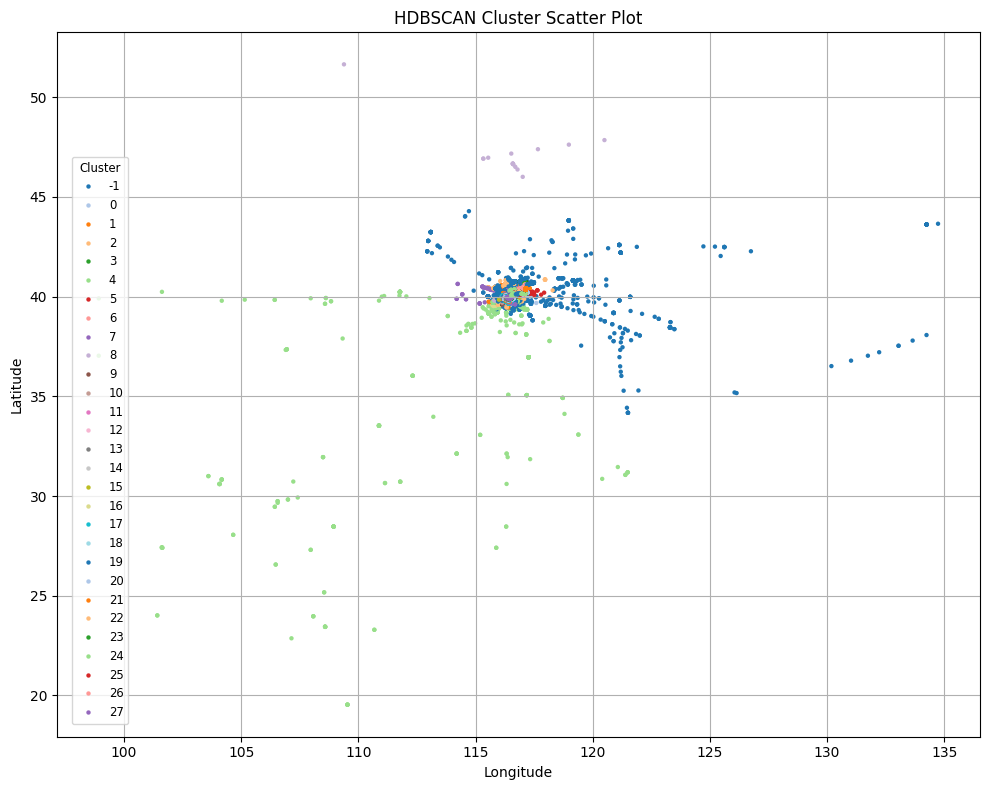

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=df_cleaned,
    x='longitude', y='latitude',
    hue='cluster',
    palette='tab20',
    s=10,
    linewidth=0,
    legend='full'  # Show full legend
)

# Put the legend inside the plot in a corner
plt.legend(
    title='Cluster',
    loc='lower left',           # or 'upper right', 'center left', etc.
    bbox_to_anchor=(0.01, 0.01),  # x, y (fraction of axes size)
    fontsize='small',
    title_fontsize='small',
    frameon=True
)

plt.title('HDBSCAN Cluster Scatter Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
len(df_cleaned)

796423

In [92]:
df_cleaned['outlier'] = (df_cleaned['cluster'] == -1).astype(int)
df_cleaned.head(10)

,taxiid,timestamp,longitude,latitude,ts_num,lat_scaled,lon_scaled,time_scaled,cluster,outlier
0,3305,2008-02-02 13:34:25,116.46689,39.99742,221.0,0.322839,0.234605,-5.916557,20,0
1,3305,2008-02-02 13:39:23,116.46693,39.99744,519.0,0.322942,0.234763,-5.909243,20,0
2,3305,2008-02-02 13:39:26,116.46693,39.99744,522.0,0.322942,0.234763,-5.909169,20,0
3,3305,2008-02-02 13:44:25,116.46690,39.99743,821.0,0.322891,0.234644,-5.901830,20,0
4,3305,2008-02-02 13:44:28,116.46690,39.99743,824.0,0.322891,0.234644,-5.901756,20,0
5,3305,2008-02-02 13:49:27,116.46622,39.99356,1123.0,0.303080,0.231942,-5.894418,20,0
6,3305,2008-02-02 13:49:30,116.46622,39.99356,1126.0,0.303080,0.231942,-5.894344,20,0
7,3305,2008-02-02 13:54:29,116.46619,39.99353,1425.0,0.302927,0.231823,-5.887005,20,0
8,3305,2008-02-02 13:54:32,116.46619,39.99353,1428.0,0.302927,0.231823,-5.886932,20,0
9,3305,2008-02-02 13:59:30,116.47245,40.00585,1726.0,0.365992,0.256702,-5.879617,20,0


In [93]:


from datetime import datetime
from google.colab import files
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
df_cleaned.to_csv(f"hdbscan_clustered_output_{timestamp}.csv", index=False)

files.download(f"hdbscan_clustered_output_{timestamp}.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>